# Semi-linear SDE solvers

We simulate the following semi-linear SDE:
$$
    dY_t = -Y_t dt + c f(Y_t) dt + dW_t
$$

where $f$ is some non-linear function (see `drift_f` below) and $c$ is a constant, which we vary between 1.0, 0.1, and 0.01. We compare the strong order of convergence of SemiShARK, SemiSEA, and ShARK for this SDE.

In [1]:
from warnings import simplefilter

import jax
import jax.numpy as jnp
import jax.random as jr


simplefilter(action="ignore", category=FutureWarning)

from test.helpers import SDE

from diffrax import (
    ControlTerm,
    MultiTerm,
    SemiLinearTerm,
    SemiShARK,
    SpaceTimeLevyArea,
)
from drawing_and_evaluating import (
    constant_step_strong_order,
    draw_order_multiple_dict,
    load_order_results,
    save_order_results,
)


jax.config.update("jax_enable_x64", True)

y0 = jnp.array([1.0, 1.0])
t0, t1 = 0.0, 8.0


def get_semi_sde(t0, t1, y0, c):
    def drift_f(t, y, args):
        dy0 = (y[0] * y[1]) / jnp.sum(y**2)
        dy1 = y[1] * (y[0] ** 2) / (1 + 0.1 * y[0] ** 4)
        return c * jnp.array([dy0, dy1], dtype=y.dtype)

    semi_term = SemiLinearTerm(f=drift_f, gamma=-1.0)
    ode_term = semi_term.to_ode()

    def diffusion_vf(t, y, args):
        return jnp.eye(2)

    def get_terms_semi(bm):
        return MultiTerm(semi_term, ControlTerm(diffusion_vf, bm))

    def get_terms_regular(bm):
        return MultiTerm(ode_term, ControlTerm(diffusion_vf, bm))

    vbt_shape = (2,)

    sde_semi = SDE(get_terms_semi, None, y0, t0, t1, vbt_shape)
    sde_regular = SDE(get_terms_regular, None, y0, t0, t1, vbt_shape)

    return sde_semi, sde_regular


c1, c2, c3 = 1.0, 0.1, 0.01

sde1_semi, sde1_regular = get_semi_sde(t0, t1, y0, c1)
sde2_semi, sde2_regular = get_semi_sde(t0, t1, y0, c2)
sde3_semi, sde3_regular = get_semi_sde(t0, t1, y0, c3)

num_samples = 1000
keys = jr.split(jr.key(0), num_samples)

bm_tol = 2**-11
levels = (5, 10)
lv_crs, lv_fine = levels
lv_ref = 14

In [2]:
# compute the reference solutions using ShARK
# ref_sols1 = get_fine_solutions(
#     keys, sde1_regular, ShARK(), SpaceTimeLevyArea, bm_tol, lv_crs, lv_ref
# )
# save_ref_sol(ref_sols1, "semi_sde_c1")
ref_sols1 = jnp.load("data/ref_sol_semi_sde_c1.npy")

# ref_sols2 = get_fine_solutions(
#     keys, sde2_regular, ShARK(), SpaceTimeLevyArea, bm_tol, lv_crs, lv_ref
# )
# save_ref_sol(ref_sols2, "semi_sde_c2")
ref_sols2 = jnp.load("data/ref_sol_semi_sde_c2.npy")

# ref_sols3 = get_fine_solutions(
#     keys, sde3_regular, ShARK(), SpaceTimeLevyArea, bm_tol, lv_crs, lv_ref
# )
# save_ref_sol(ref_sols3, "semi_sde_c3")
ref_sols3 = jnp.load("data/ref_sol_semi_sde_c3.npy")

In [3]:
# compute the strong order of convergence for SDE 1

# First for SemiShARK
semi_shark_out1 = constant_step_strong_order(
    keys,
    sde1_semi,
    SemiShARK(),
    levels,
    bm_tol=bm_tol,
    levy_area=SpaceTimeLevyArea,
    ref_sol=ref_sols1,
)
save_order_results(semi_shark_out1, "semi_sde1_SemiShARK")
semi_shark_out1 = load_order_results("semi_sde1_SemiShARK")

# Second for SemiSEA
# semi_sea_out1 = constant_step_strong_order(
#     keys, sde1_semi, SemiSEA(), levels, bm_tol=bm_tol, ref_sol=ref_sols1
# )
# save_order_results(semi_sea_out1, "semi_sde1_SemiSEA")
semi_sea_out1 = load_order_results("semi_sde1_SemiSEA")

# Third for ShARK
# shark_out1 = constant_step_strong_order(
#     keys,
#     sde1_regular,
#     ShARK(),
#     levels,
#     bm_tol=bm_tol,
#     levy_area=SpaceTimeLevyArea,
#     ref_sol=ref_sols1,
# )
# save_order_results(shark_out1, "semi_sde1_ShARK")
shark_out1 = load_order_results("semi_sde1_ShARK")

Saved data/order_results_semi_sde1_SemiShARK.npy
Loaded data/order_results_semi_sde1_SemiShARK.npy
Loaded data/order_results_semi_sde1_SemiSEA.npy
Loaded data/order_results_semi_sde1_ShARK.npy


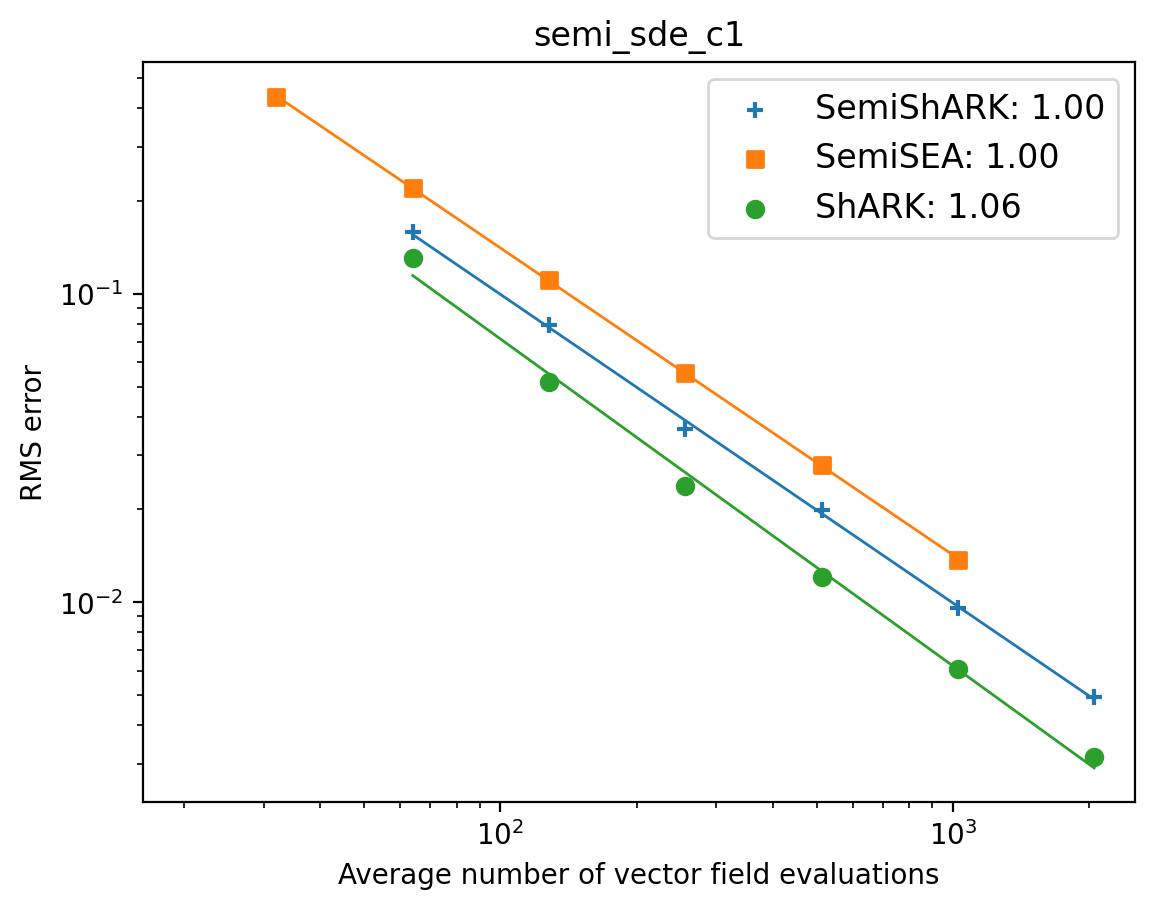

In [4]:
# Plot the orders of convergence

_ = draw_order_multiple_dict(
    {"SemiShARK": semi_shark_out1, "SemiSEA": semi_sea_out1, "ShARK": shark_out1},
    "semi_sde_c1",
)

In [5]:
# compute the strong order of convergence for SDE 2
semi_shark_out2 = constant_step_strong_order(
    keys,
    sde2_semi,
    SemiShARK(),
    levels,
    bm_tol=bm_tol,
    levy_area=SpaceTimeLevyArea,
    ref_sol=ref_sols2,
)
save_order_results(semi_shark_out2, "semi_sde2_SemiShARK")
semi_shark_out2 = load_order_results("semi_sde2_SemiShARK")

# semi_sea_out2 = constant_step_strong_order(
#     keys, sde2_semi, SemiSEA(), levels, bm_tol=bm_tol, ref_sol=ref_sols2
# )
# save_order_results(semi_sea_out2, "semi_sde2_SemiSEA")
semi_sea_out2 = load_order_results("semi_sde2_SemiSEA")

# shark_out2 = constant_step_strong_order(
#     keys,
#     sde2_regular,
#     ShARK(),
#     levels,
#     bm_tol=bm_tol,
#     levy_area=SpaceTimeLevyArea,
#     ref_sol=ref_sols2,
# )
# save_order_results(shark_out2, "semi_sde2_ShARK")
shark_out2 = load_order_results("semi_sde2_ShARK")

Saved data/order_results_semi_sde2_SemiShARK.npy
Loaded data/order_results_semi_sde2_SemiShARK.npy
Loaded data/order_results_semi_sde2_SemiSEA.npy
Loaded data/order_results_semi_sde2_ShARK.npy


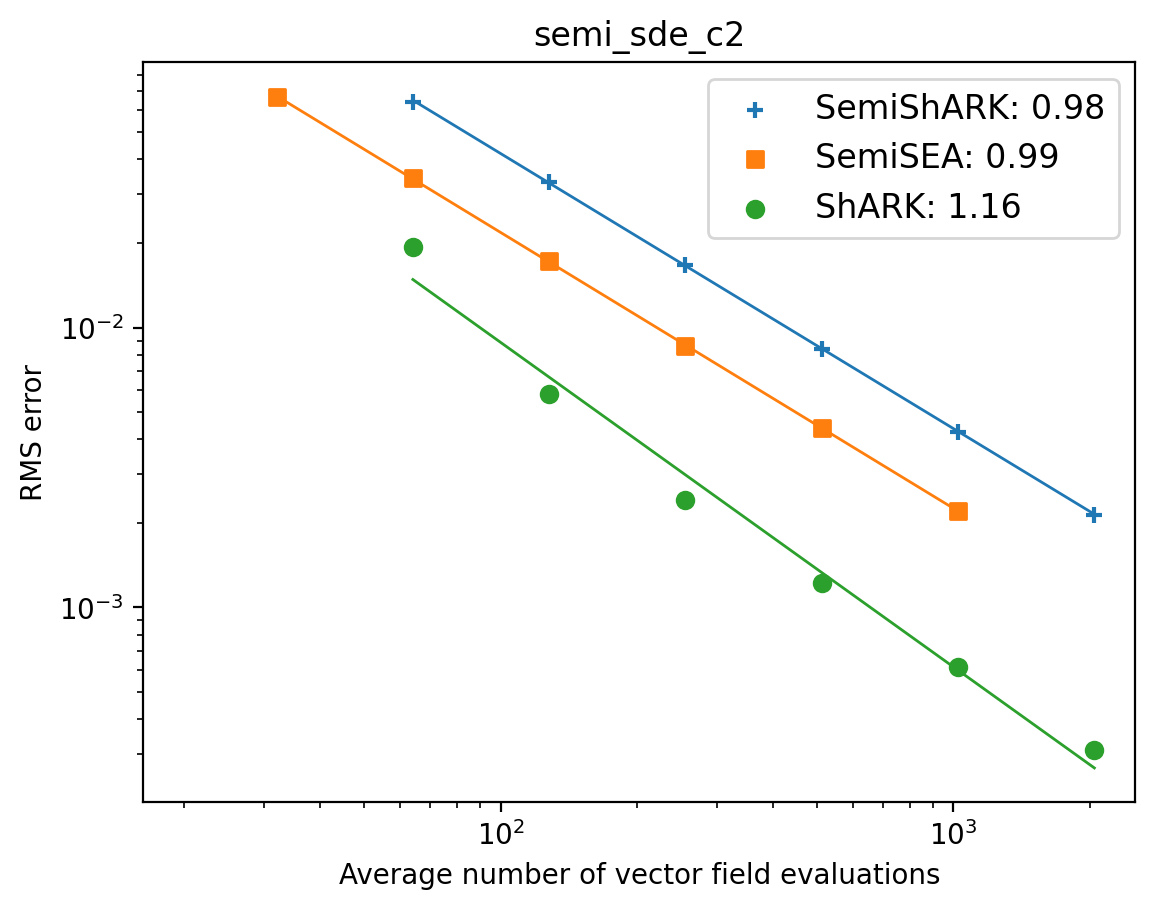

In [6]:
# Plot the orders of convergence
_ = draw_order_multiple_dict(
    {"SemiShARK": semi_shark_out2, "SemiSEA": semi_sea_out2, "ShARK": shark_out2},
    "semi_sde_c2",
)

In [7]:
# compute the strong order of convergence for SDE 3
semi_shark_out3 = constant_step_strong_order(
    keys,
    sde3_semi,
    SemiShARK(),
    levels,
    bm_tol=bm_tol,
    levy_area=SpaceTimeLevyArea,
    ref_sol=ref_sols3,
)
save_order_results(semi_shark_out3, "semi_sde3_SemiShARK")
semi_shark_out3 = load_order_results("semi_sde3_SemiShARK")

# semi_sea_out3 = constant_step_strong_order(
#     keys, sde3_semi, SemiSEA(), levels, bm_tol=bm_tol, ref_sol=ref_sols3
# )
# save_order_results(semi_sea_out3, "semi_sde3_SemiSEA")
semi_sea_out3 = load_order_results("semi_sde3_SemiSEA")

# shark_out3 = constant_step_strong_order(
#     keys,
#     sde3_regular,
#     ShARK(),
#     levels,
#     bm_tol=bm_tol,
#     levy_area=SpaceTimeLevyArea,
#     ref_sol=ref_sols3,
# )
# save_order_results(shark_out3, "semi_sde3_ShARK")
shark_out3 = load_order_results("semi_sde3_ShARK")

Saved data/order_results_semi_sde3_SemiShARK.npy
Loaded data/order_results_semi_sde3_SemiShARK.npy
Loaded data/order_results_semi_sde3_SemiSEA.npy
Loaded data/order_results_semi_sde3_ShARK.npy


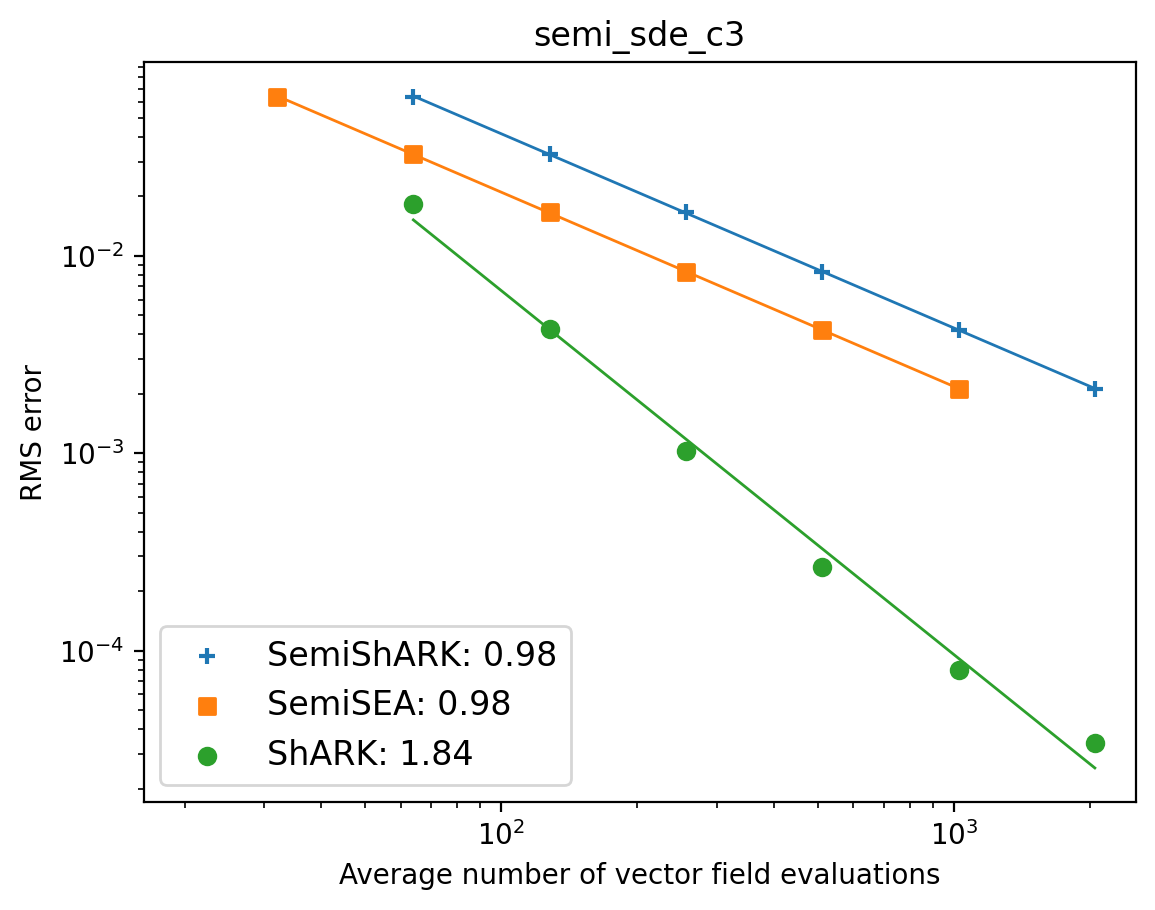

In [8]:
# Plot the orders of convergence

_ = draw_order_multiple_dict(
    {"SemiShARK": semi_shark_out3, "SemiSEA": semi_sea_out3, "ShARK": shark_out3},
    "semi_sde_c3",
)